In [1]:
import numpy as np
import pandas as pd

import ipympl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

print(matplotlib.get_backend())

import data_util as du
import performance_util as pu
import bayes_classifier as bayes
import knn_classifier as knn

from sklearn.decomposition import PCA
# from PCA import PCA
import kmeans

%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
# %matplotlib agg

module://ipympl.backend_nbagg


In [2]:
data_dir = '../data/Medical_data.csv'
random_seed = 1
np.set_printoptions(precision=4)

In [3]:
label_map = {'HEALTHY':0, 'SURGERY':1, 'MEDICATION':2}
X, Y = du.load_medical(data_dir, label_map = label_map)
print(X.shape)
print(Y.shape)

print(X[:3, :])
print(Y[:3, :])

(3000, 3)
(3000, 1)
[[ 1.6315 -0.2644  2.5346]
 [ 0.154   1.4195  1.3331]
 [ 2.0217  0.262   2.88  ]]
[[0]
 [1]
 [0]]


/home/manas/Academics/sem_7/ell409/assignment/assign1/src/data_util.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = df[['TEST1' , 'TEST2', 'TEST3']].as_matrix()
/home/manas/Academics/sem_7/ell409/assignment/assign1/src/data_util.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y = df[['Health']].as_matrix()


### VISUALIZATION

(array([1000., 1000., 1000.]),
 array([0.    , 0.6667, 1.3333, 2.    ]),
 <a list of 3 Patch objects>)

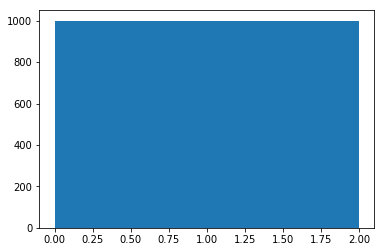

In [4]:
plt.hist(Y, bins = 3)

FigureCanvasNbAgg()

[Text(1,0,'HEALTHY'), Text(1,0,'SURGERY'), Text(1,0,'MEDICATION')]

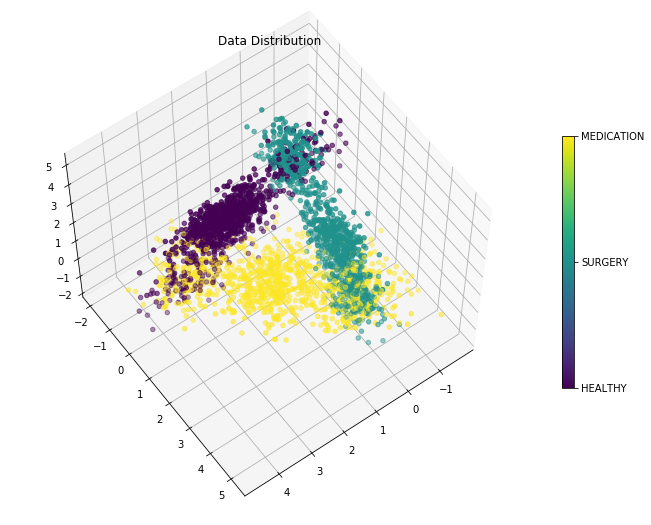

In [5]:
%matplotlib widget
fig = plt.figure(figsize=(9,7))

ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=60, azim=54)
# ax = plt.axes(projection='3d')
cax = ax.scatter3D(X[:,0], X[:,1], X[:,2], c = Y[:,0])
ax.set_title('Data Distribution')


# cax = ax.imshow(X, interpolation='nearest', cmap=cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1, 2], shrink = 0.5)
cbar.ax.set_yticklabels(['HEALTHY', 'SURGERY', 'MEDICATION'])

### PCA

In [6]:
pca = PCA(n_components = 2)
pca.fit(X)
print(np.sum(pca.explained_variance_ratio_))

0.9352761773710134


[Text(1,0,'HEALTHY'), Text(1,0,'SURGERY'), Text(1,0,'MEDICATION')]

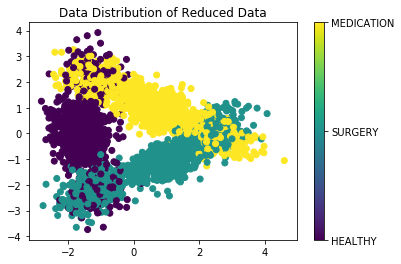

In [7]:
X_transformed = pca.transform(X)

%matplotlib inline
fig = plt.figure()

cax = plt.scatter(X_transformed[:,0], X_transformed[:,1], c = Y[:,0])
plt.title('Data Distribution of Reduced Data')

cbar = fig.colorbar(cax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['HEALTHY', 'SURGERY', 'MEDICATION'])

## SUPERVISED LEARNING

### Data Preprocessing

In [8]:
X_train, Y_train, X_test, Y_test = du.split_data(X, Y, train_ratio = 0.8, random_state = random_seed)
X_train, Y_train, X_dev, Y_dev = du.split_data(X_train, Y_train, train_ratio = 0.75, random_state = random_seed)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_dev.shape)
print(Y_dev.shape)

(1800, 3)
(1800, 1)
(600, 3)
(600, 1)
(600, 3)
(600, 1)


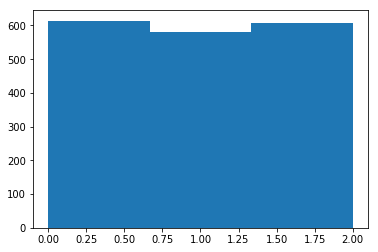

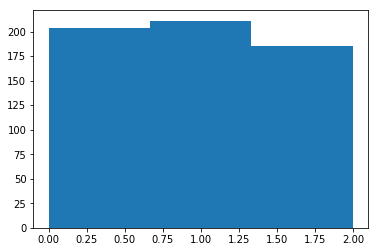

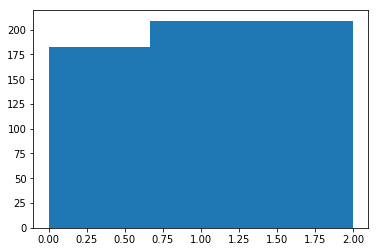

In [9]:
%matplotlib inline
plt.hist(Y_train, bins = 3)
plt.show()
plt.hist(Y_test, bins = 3)
plt.show()
plt.hist(Y_dev, bins = 3)
plt.show()

In [10]:
# Normalize w.r.t train data
# https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

X_train, mu, std = du.normalize(X_train)
X_dev = (X_dev - mu) / std
X_test = (X_test - mu) / std

#### REDUCTION to 2 COMPONENTS - PCA

In [11]:
pca_2 = PCA(n_components = 2)
pca_2.fit(X_train)
print(np.sum(pca_2.explained_variance_ratio_))

0.9375477670207449


In [12]:
X_train_reduced = pca_2.transform(X_train)
X_dev_reduced = pca_2.transform(X_dev)
X_test_reduced = pca_2.transform(X_test)

### KNN CLASSIFIER

####  3D DATA

##### Training and Parameter Tuning

In [13]:
# (no. of neighbours, minkowski parameter) 
knn_parameters = [(1, 1), (5, 1), (10, 1), (15, 1), 
                  (1, 2), (5, 2), (10, 2), (15, 2),
                  (1, 3), (5, 3), (10, 3), (15, 3), 
                  (1, np.inf), (5, np.inf), (10, np.inf), (15, np.inf), 
                  (1, -np.inf), (5, -np.inf), (10, -np.inf), (15, -np.inf)]

    
for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()

Number of Neighbours = 1 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.88
Precision per Class
[0.8859 0.9005 0.8558]
Recall per Class
[0.8956 0.866  0.8804]
F1 Score per Class
[0.8907 0.8829 0.8679]
Macro Average Precision, Recall and F1 Score
[0.8807 0.8807 0.8807]
Micro Average Precision, Recall and F1 Score
[0.88 0.88 0.88]


Number of Neighbours = 5 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8916666666666667
Precision per Class
[0.9458 0.8821 0.8604]
Recall per Class
[0.8626 0.8947 0.9139]
F1 Score per Class
[0.9023 0.8884 0.8863]
Macro Average Precision, Recall and F1 Score
[0.8961 0.8904 0.8932]
Micro Average Precision, Recall and F1 Score
[0.8917 0.8917 0.8917]


Number of Neighbours = 10 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8816666666666667
Precision per Class
[0.9455 0.8514 0.8638]
Recall per Class
[0.8571 0.9043 0.8804]
F1 Score per Class
[0.8991 0.877  0.872 ]
Macro Average Precision, Recall and F1 Score
[0.8869 0.8806 0.8837]
Micro Average Precisi

#####  Testing

In [14]:
knn_parameters = [(5, 2)]

for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Test Set = ", pu.model_accuracy(Y_pred, Y_test))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_test, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_test, 3))
    
    print()
    print()

Number of Neighbours = 5 , Minkowski Parameter = 2
Accuracy on Test Set =  0.8933333333333333
Precision per Class
[0.9381 0.8879 0.8542]
Recall per Class
[0.8922 0.9005 0.8865]
F1 Score per Class
[0.9146 0.8941 0.87  ]
Macro Average Precision, Recall and F1 Score
[0.8934 0.893  0.8932]
Micro Average Precision, Recall and F1 Score
[0.8933 0.8933 0.8933]




##### Training and Parameter Tuning

In [15]:
# (no. of neighbours, minkowski parameter) 
knn_parameters = [(1, 1), (5, 1), (10, 1), (15, 1), 
                  (1, 2), (5, 2), (10, 2), (15, 2),
                  (1, 3), (5, 3), (10, 3), (15, 3), 
                  (1, np.inf), (5, np.inf), (10, np.inf), (15, np.inf), 
                  (1, -np.inf), (5, -np.inf), (10, -np.inf), (15, -np.inf)]

np.set_printoptions(precision=4)
    
for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train_reduced, Y_train)
    Y_pred = model.predict(X_dev_reduced)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()

Number of Neighbours = 1 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8166666666666667
Precision per Class
[0.7979 0.8155 0.835 ]
Recall per Class
[0.8242 0.8038 0.823 ]
F1 Score per Class
[0.8108 0.8096 0.8289]
Macro Average Precision, Recall and F1 Score
[0.8161 0.817  0.8166]
Micro Average Precision, Recall and F1 Score
[0.8167 0.8167 0.8167]


Number of Neighbours = 5 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.855
Precision per Class
[0.8929 0.8433 0.8372]
Recall per Class
[0.8242 0.8756 0.8612]
F1 Score per Class
[0.8571 0.8592 0.8491]
Macro Average Precision, Recall and F1 Score
[0.8578 0.8537 0.8557]
Micro Average Precision, Recall and F1 Score
[0.855 0.855 0.855]


Number of Neighbours = 10 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8466666666666667
Precision per Class
[0.8882 0.813  0.85  ]
Recall per Class
[0.8297 0.8947 0.8134]
F1 Score per Class
[0.858  0.8519 0.8313]
Macro Average Precision, Recall and F1 Score
[0.8504 0.8459 0.8482]
Micro Average Pre

#### Performance After PCA decreased using KNN Classifier
#### KNN BEST PARAMETERS 
#### 3D DATA, k = 5, p = 2

### BAYES CLASSIFIER

#### GMM class conditional distribution

In [17]:
dimension = X_train.shape[1]

gmm_parameters = [[2, 0.01, 100, dimension, 0.0001],  [2, 0.001, 100, dimension, 0.0001],
                  [2, 0.0001, 100, dimension, 0.0001],[2, 0.00001, 100, dimension, 0.0001],
                  [3, 0.01, 100, dimension, 0.0001],  [3, 0.001, 100, dimension, 0.0001],
                  [3, 0.0001, 100, dimension, 0.0001],[3, 0.00001, 100, dimension, 0.0001],
                  [4, 0.01, 100, dimension, 0.0001],  [4, 0.001, 100, dimension, 0.0001],
                  [4, 0.0001, 100, dimension, 0.0001],[4, 0.00001, 100, dimension, 0.0001],
                  [5, 0.01, 100, dimension, 0.0001],  [5, 0.001, 100, dimension, 0.0001],
                  [5, 0.0001, 100, dimension, 0.0001],[5, 0.00001, 100, dimension, 0.0001],]

    
for par in gmm_parameters:
    model = bayes.bayes_classifier(estimator_type = 'GMM', param = par)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Number of Components = %s , Number of max EM iterations = %s" % (str(par[0]), str(par[2])))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()


Converged after 16 iterations
Converged after 59 iterations
Converged after 32 iterations
Number of Components = 2 , Number of max EM iterations = 100
Accuracy on Dev Set =  0.895
Precision per Class
[0.9458 0.8667 0.8852]
Recall per Class
[0.8626 0.933  0.8852]
F1 Score per Class
[0.9023 0.8986 0.8852]
Macro Average Precision, Recall and F1 Score
[0.8992 0.8936 0.8964]
Micro Average Precision, Recall and F1 Score
[0.895 0.895 0.895]


Converged after 21 iterations
Converged after 68 iterations
Converged after 100 iterations
Number of Components = 2 , Number of max EM iterations = 100
Accuracy on Dev Set =  0.895
Precision per Class
[0.9458 0.8667 0.8852]
Recall per Class
[0.8626 0.933  0.8852]
F1 Score per Class
[0.9023 0.8986 0.8852]
Macro Average Precision, Recall and F1 Score
[0.8992 0.8936 0.8964]
Micro Average Precision, Recall and F1 Score
[0.895 0.895 0.895]


Converged after 18 iterations
Converged after 74 iterations
Converged after 100 iterations
Number of Components = 2 , N